The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [1]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from homegrad.nn import Module
from homegrad.nn import Neuron
from homegrad.nn import Layer
from homegrad.nn import MLPerceptron
from homegrad.engine import * 
from homegrad.drawer import * 

%matplotlib inline

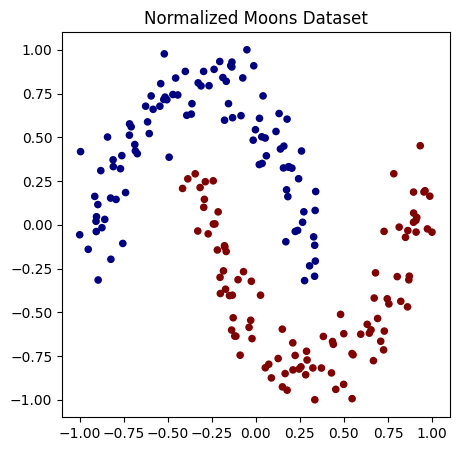

In [2]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 200, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# Min-max normalization for X between -1 and 1
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min) - 1

# Visualize normalized data in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=y, s=20, cmap='jet')
plt.title("Normalized Moons Dataset")
plt.show()

In [3]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(200, 2)


In [12]:

#print(MLPerceptron.__init__.__code__.co_varnames)
n = MLPerceptron(2,[6,12,6,1], activations = ['tanh', 'tanh','relu', 'none' ])
print(n)
print(len(n.parameters()))



MLP of [Layer of [Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2)], Layer of [Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6), Tanh Neuron(6)], Layer of [ReLu Neuron(12), ReLu Neuron(12), ReLu Neuron(12), ReLu Neuron(12), ReLu Neuron(12), ReLu Neuron(12)], Layer of [Linear Neuron(6)]]
187


In [13]:
# loss function
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # svm "max-margin" loss
    losses = [(Value(1) + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)



total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.2614613941985955, grad=0) 0.5


In [14]:
print(f"Initial loss: {total_loss.data}, accuracy: {acc*100}%")
print("Some initial parameter values:", [p.data for p in n.parameters()[:5]])

Initial loss: 1.2614613941985955, accuracy: 50.0%
Some initial parameter values: [0.8349549602251107, 0.0028442591176625065, 0, 0.6753580387541873, 0.6869512232969401]


In [7]:
#Drawing function, takes too long to run for some reason? 
#draw_dot(total_loss)

In [8]:
#Testing draw_dot
#draw_dot(n((0.5,0.5)))

In [15]:
for k in range(100):
    # forward
    total_loss, acc = loss()
    
    # backward
    n.zero_grad()
    total_loss.backward()
    
    # Debugging: Check gradients
    if k == 0:
        print("Some initial gradients:", [p.grad for p in n.parameters()[:5]])
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in n.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        # Debugging: Check updated parameter values
        print("Some updated parameter values:", [p.data for p in n.parameters()[:5]])

Some initial gradients: [-0.13968731210940866, 0.24938375148044623, 0.03455761355462311, 0.059122592718471756, -0.08350832113046275]
step 0 loss 1.2614613941985955, accuracy 50.0%
Some updated parameter values: [0.9746422723345194, -0.24653949236278372, -0.03455761355462311, 0.6162354460357156, 0.7704595444274029]
step 10 loss 0.2559631601966995, accuracy 89.5%
Some updated parameter values: [0.6087060340103702, -0.7299242955458718, 0.005138111360009426, 0.5883725449209104, 0.9453641029608019]
step 20 loss 0.24795307976556974, accuracy 90.0%
Some updated parameter values: [0.559842912567496, -0.7349687718643056, 0.028761265828139572, 0.7599938704294146, 0.9271158160677869]
step 30 loss 0.11166021193073264, accuracy 95.0%
Some updated parameter values: [0.5975321751892888, -0.6986795081009992, 0.08091690800973775, 0.9264702819828814, 0.891463643563072]
step 40 loss 0.17167250264249512, accuracy 93.5%
Some updated parameter values: [0.6222186412881837, -0.7313412225300979, 0.056176251940

In [16]:
#testing
print(n.layers[0].neurons[3].w[0].grad)

0.004099148006667916


Final loss: 0.013709749034207208, accuracy: 100.0%


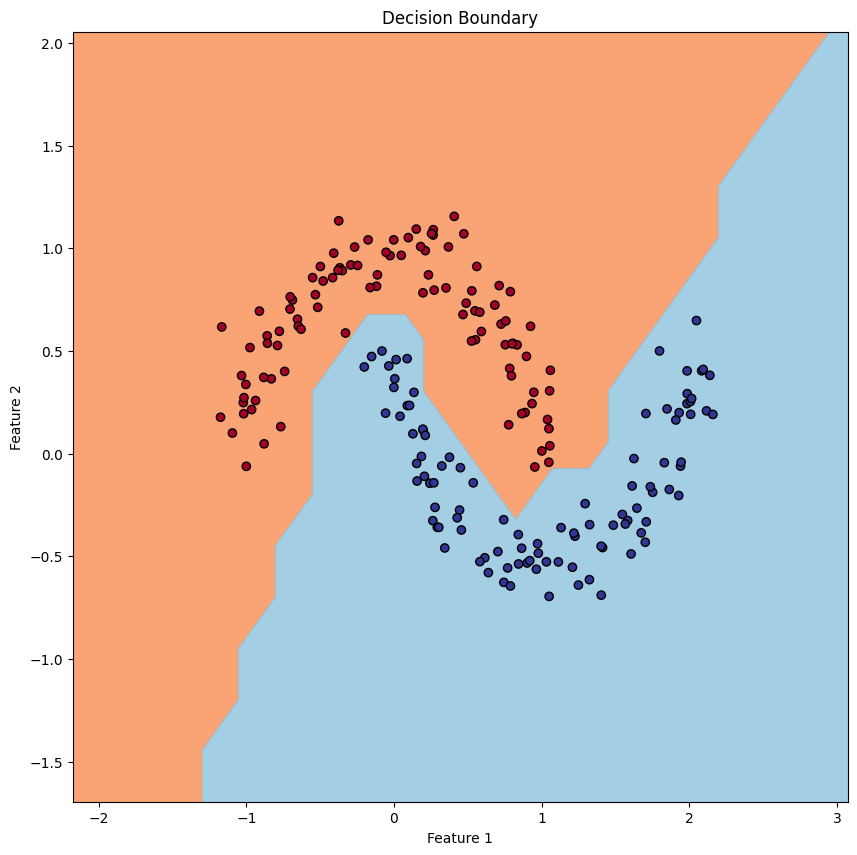

In [17]:
# visualize decision boundary

# Final evaluation
final_loss, final_acc = loss()
print(f"Final loss: {final_loss.data}, accuracy: {final_acc*100}%")

# Plot decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()